# <center>DataLab Cup 2: CNN for Object Detection</center>

<center>Shan-Hung Wu & DataLab</center>

<center>Fall 2023</center>


## Competition Info

In this competition, you have to train a model that recognizes objects in an image. Your goal is to output bounding boxes for objects.

## Platform: [Kaggle](https://www.kaggle.com/t/271c180ff95e4c279756727707cf32b2)

## Problem description

Given an image(shape = [undefined, undefined, 3]), you need to output bounding box ($xmin, ymin, xmax, ymax$, class_label, confidence_score) for objects showed in image and its class. [picture source](https://leonardoaraujosantos.gitbook.io/artificial-inteligence/machine_learning/deep_learning/object_localization_and_detection)

![](https://nthu-datalab.github.io/ml/competitions/Comp_02_Object-Detection/img_src/LocalizationDetection.png)

## Data provided

### Dataset: [PASCAL VOC2007](http://host.robots.ox.ac.uk/pascal/VOC/voc2007/)

The dataset contains 20 classes. The train/val data has 5012 images containing 12608 annotated objects. We have preprocessed training dataset(5012 images) and testing dataset(4953 images) for you. You can download them on Kaggle.


In [60]:
classes_name =  ["aeroplane", "bicycle", "bird", "boat", "bottle", 
                 "bus", "car", "cat", "chair", "cow", "diningtable", 
                 "dog", "horse", "motorbike", "person", "pottedplant", 
                 "sheep", "sofa", "train","tvmonitor"]

### Processed data format

The information for each image of training data are recorded in `VOCdevkit_train/VOC2007/Annotations`. However, we have processed those files for you into one record file: `pascal_voc_training_data.txt` in which each line records informations of each training images.

The data format of pascal_voc_training_data is:

> [image_name, $xmin_i , ymin_i , xmax_i , ymax_i , class_i$] (repeat number of objects times)

In [61]:
training_data_file = open("./datasets/pascal_voc_training_data.txt", "r")
for i, line in enumerate(training_data_file):
    if i >5:
        break
    line = line.strip()
    print(line)

000005.jpg 263 211 324 339 8 165 264 253 372 8 5 244 67 374 8 241 194 295 299 8 277 186 312 220 8
000007.jpg 141 50 500 330 6
000009.jpg 69 172 270 330 12 150 141 229 284 14 285 201 327 331 14 258 198 297 329 14
000012.jpg 156 97 351 270 6
000016.jpg 92 72 305 473 1
000017.jpg 185 62 279 199 14 90 78 403 336 12


As you can see, one image may have multiple objects. Another thing to note is, the heights and widths of the images in this datset are different. Therefore, you are suggested to reshape images and ground truth bounding boxes' coordinates into same size.

In this competition, you can implement all kinds of object detection models (R-CNN, Fast-RCNN, Faster-RCNN, YOLOs, SSD,...etc.). Here we provide a simple template based on [YOLO(You Only Look Once)](https://pjreddie.com/media/files/papers/yolo.pdf).


In [62]:
import tensorflow as tf
import numpy as np

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Select GPU number 1
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

#### Hyperparameters

In [64]:
# common params
IMAGE_SIZE = 448
BATCH_SIZE = 32
NUM_CLASSES = 20
MAX_OBJECTS_PER_IMAGE = 20

# dataset params
DATA_PATH = './datasets/pascal_voc_training_data.txt'
IMAGE_DIR = './datasets/VOCdevkit_train/VOC2007/JPEGImages/'

# model params
CELL_SIZE = 7
BOXES_PER_CELL = 2
OBJECT_SCALE = 1
NOOBJECT_SCALE = 0.5
CLASS_SCALE = 1
COORD_SCALE = 5

# training params
LEARNING_RATE = 1e-4
EPOCHS = 3

In [5]:
from tensorflow import keras
from tensorflow.keras import layers

def conv_norm_act(inputs, filters, size, stride):
    x = layers.Conv2D(filters, size, stride, padding="same",
                      kernel_initializer=tf.keras.initializers.TruncatedNormal())(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.1)(x)
    
    return x

In [7]:
input_image = layers.Input((448, 448, 3))

densenet = keras.applications.DenseNet201(
    include_top=False,
    input_tensor=input_image,
    input_shape=(448, 448, 3)
    )
densenet.trainable = False

x = densenet.output
x = conv_norm_act(x, 1024, 3, 1)
x = conv_norm_act(x, 1024, 3, 2)
x = conv_norm_act(x, 1024, 3, 1)
x = conv_norm_act(x, 1024, 3, 1)
x = layers.Flatten()(x)
x = layers.Dense(4096, 
                 kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)
x = layers.LeakyReLU(0.1)(x)
outputs = layers.Dense(1470, 
                       kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)

YOLO = keras.Model(inputs=input_image, outputs=outputs, name="YOLO")

In [8]:
YOLO.summary()

Model: "YOLO"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 448, 448, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 454, 454, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 224, 224, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 224, 224, 64) 256         conv1/conv[0][0]                 
_______________________________________________________________________________________________

## Dataset Loader

We define a class especially to process training data, reading the records from `pascal_voc_training_data.txt` and follow the steps below to prepare data for our network:

1. Create Dataset using tensorflow data API.
2. In Dataset map function, read images and do preprocessing(ex. resizing , normalization).
3. In Dataset map function, change box information `[xmin, ymin, xmax, ymax]` coordinates into `[xcenter, ycenter, width, height]` attributes, which is easier for YOLO model to use.
4. Batch, Shuffle operations.



In [65]:
class DatasetGenerator:
    """
    Load pascalVOC 2007 dataset and creates an input pipeline.
    - Reshapes images into 448 x 448
    - converts [0 1] to [-1 1]
    - shuffles the input
    - builds batches
    """

    def __init__(self):
        self.image_names = []
        self.record_list = []
        self.object_num_list = []
        # filling the record_list
        input_file = open(DATA_PATH, 'r')

        for line in input_file:
            line = line.strip()
            ss = line.split(' ')
            self.image_names.append(ss[0])

            self.record_list.append([float(num) for num in ss[1:]])

            self.object_num_list.append(min(len(self.record_list[-1])//5, 
                                            MAX_OBJECTS_PER_IMAGE))
            if len(self.record_list[-1]) < MAX_OBJECTS_PER_IMAGE*5:
                # if there are objects less than MAX_OBJECTS_PER_IMAGE, pad the list
                self.record_list[-1] = self.record_list[-1] +\
                [0., 0., 0., 0., 0.]*\
                (MAX_OBJECTS_PER_IMAGE-len(self.record_list[-1])//5)
                
            elif len(self.record_list[-1]) > MAX_OBJECTS_PER_IMAGE*5:
               # if there are objects more than MAX_OBJECTS_PER_IMAGE, crop the list
                self.record_list[-1] = self.record_list[-1][:MAX_OBJECTS_PER_IMAGE*5]

    def _data_preprocess(self, image_name, raw_labels, object_num):
        image_file = tf.io.read_file(IMAGE_DIR+image_name)
        image = tf.io.decode_jpeg(image_file, channels=3)

        h = tf.shape(image)[0]
        w = tf.shape(image)[1]

        width_ratio  = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32) 
        height_ratio = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32) 

        image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = (image/255) * 2 - 1

        raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)

        xmin = raw_labels[:, 0]
        ymin = raw_labels[:, 1]
        xmax = raw_labels[:, 2]
        ymax = raw_labels[:, 3]
        class_num = raw_labels[:, 4]

        xcenter = (xmin + xmax) * 1.0 / 2.0 * width_ratio
        ycenter = (ymin + ymax) * 1.0 / 2.0 * height_ratio

        box_w = (xmax - xmin) * width_ratio
        box_h = (ymax - ymin) * height_ratio

        labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis=1)

        return image, labels, tf.cast(object_num, tf.int32)

    def generate(self):
        dataset = tf.data.Dataset.from_tensor_slices((self.image_names, 
                                                      np.array(self.record_list), 
                                                      np.array(self.object_num_list)))
        dataset = dataset.shuffle(100000)
        dataset = dataset.map(self._data_preprocess, 
                              num_parallel_calls = tf.data.experimental.AUTOTUNE)
        dataset = dataset.batch(BATCH_SIZE)
        dataset = dataset.prefetch(buffer_size=200)

        return dataset

Now we can simply new a `DatasetGenerator` which can provide batches of training data for our model.

## Object Detection Model (YOLO)

Different from Region Proposal based model, YOLO divide an image into cell_size×
cell_size (say 7×7) cells, each has fixed number of output prediction boxes(coordinates, class_number, and confidence score). The final prediction would be the boxes with highest confidence score. The prediction of YOLO can be based on the output features extracted by the convolutional layers on the input image, which is actually "look once" on each image.

![](https://nthu-datalab.github.io/ml/competitions/Comp_02_Object-Detection/img_src/yolo_abstract.png)

Intersection Over Union(IoU)

The loss calculation of YOLO includes calculating the intersection over union between the predicted boxes and the ground truth boxes. IoU is a common way to evaluate whether the predicted box coordinate is precise enough or not. The calcuation of iou is

$$Predicted\_Box\cap GroundTruth\_Box \over{Predicted\_Box\cup GroundTruth\_Box}$$

![](https://nthu-datalab.github.io/ml/competitions/Comp_02_Object-Detection/img_src/iou.png)

So we would like the IoU of our prediction and the ground the larger the better. In addition, IoU is also used when we evaluate an object detection model is good or not: the prediction is success if the IoU of the predicted box and the ground truth is larger than a threshould.

### Model Architecture

24 convolution layers followed by 2 fully connected layers.
Use a linear activation function for the final layer and all other layers use the following leaky rectified linear activation:

$$\phi(x)= \begin{cases}
      x, & \text{if}\ x>0 \\
      0.1x, & \text{otherwise}
    \end{cases}$$

![](https://nthu-datalab.github.io/ml/competitions/Comp_02_Object-Detection/img_src/YOLO_model_architecture.PNG)

### model

In [66]:
from tensorflow import keras
from tensorflow.keras import layers

In [67]:
def conv_leaky_relu(inputs, filters, size, stride):
    x = layers.Conv2D(filters, size, stride, padding="same",
                      kernel_initializer=tf.keras.initializers.TruncatedNormal())(inputs)
    x = layers.LeakyReLU(0.1)(x)

    return x

In [68]:
img_inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = conv_leaky_relu(img_inputs, 64, 7, 2)
x = layers.MaxPool2D()(x)
x = conv_leaky_relu(x, 192, 3, 1)
x = layers.MaxPool2D()(x)
x = conv_leaky_relu(x, 128, 1, 1)
x = conv_leaky_relu(x, 256, 3, 1)
x = conv_leaky_relu(x, 256, 1, 1)
x = conv_leaky_relu(x, 512, 3, 1)
x = layers.MaxPool2D()(x)
x = conv_leaky_relu(x, 256, 1, 1)
x = conv_leaky_relu(x, 512, 3, 1)
x = conv_leaky_relu(x, 256, 1, 1)
x = conv_leaky_relu(x, 512, 3, 1)
x = conv_leaky_relu(x, 256, 1, 1)
x = conv_leaky_relu(x, 512, 3, 1)
x = conv_leaky_relu(x, 256, 1, 1)
x = conv_leaky_relu(x, 512, 3, 1)
x = conv_leaky_relu(x, 512, 1, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = layers.MaxPool2D()(x)
x = conv_leaky_relu(x, 512, 1, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 512, 1, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 2)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = layers.Flatten()(x)
x = layers.Dense(4096, 
                 kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)
x = layers.LeakyReLU(0.1)(x)
outputs = layers.Dense(1470, 
                       kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)

YOLO = keras.Model(inputs=img_inputs, outputs=outputs, name="YOLO")

In [69]:
YOLO.summary()

Model: "YOLO"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 448, 448, 3)]     0         
                                                                 
 conv2d_48 (Conv2D)          (None, 224, 224, 64)      9472      
                                                                 
 leaky_re_lu_50 (LeakyReLU)  (None, 224, 224, 64)      0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_49 (Conv2D)          (None, 112, 112, 192)     110784    
                                                                 
 leaky_re_lu_51 (LeakyReLU)  (None, 112, 112, 192)     0         
                                                              

### Define loss

In [70]:
# base boxes (for loss calculation)
base_boxes = np.zeros([CELL_SIZE, CELL_SIZE, 4])

# initializtion for each cell
for y in range(CELL_SIZE):
    for x in range(CELL_SIZE):
        base_boxes[y, x, :] = [IMAGE_SIZE / CELL_SIZE * x, 
                               IMAGE_SIZE / CELL_SIZE * y, 0, 0]

base_boxes = np.resize(base_boxes, [CELL_SIZE, CELL_SIZE, 1, 4])
base_boxes = np.tile(base_boxes, [1, 1, BOXES_PER_CELL, 1])

In [71]:
def single_sample_loss(args):
    predict, label, object_num = args

    loss = tf.constant(0., dtype=tf.float32)

    for j in tf.range(object_num):
        results = losses_calculation(predict, label[j:j+1, :])
        loss = loss + results

    return loss

def yolo_loss(predicts, labels, objects_num):
    """
    Add Loss to all the trainable variables
    Args:
        predicts: 4-D tensor [batch_size, cell_size, cell_size, num_classes + 5 * boxes_per_cell]
        ===> (num_classes, boxes_per_cell, 4 * boxes_per_cell)
        labels  : 3-D tensor of [batch_size, max_objects, 5]
        objects_num: 1-D tensor [batch_size]
    """

    loss = 0.
    
    # you can parallel the code with tf.map_fn or tf.vectorized_map (big performance gain!)
    for i in tf.range(BATCH_SIZE):
        predict = predicts[i, :, :, :]
        label = labels[i, :, :]
        object_num = objects_num[i]

        for j in tf.range(object_num):
            results = losses_calculation(predict, label[j:j+1, :])
            loss = loss + results

    return loss/BATCH_SIZE

    # Use tf.map_fn to parallelize the computation for each sample in the batch
    # losses = tf.map_fn(single_sample_loss, (predicts, labels, objects_num), dtype=tf.float32)

    # # Compute the average loss across the batch
    # return tf.reduce_sum(losses) / BATCH_SIZE
    


def iou(boxes1, boxes2):
    """calculate ious
    Args:
      boxes1: 4-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4]  ====> (x_center, y_center, w, h)
      boxes2: 1-D tensor [4] ===> (x_center, y_center, w, h)

    Return:
      iou: 3-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
      ====> iou score for each cell
    """

    #boxes1 : [4(xmin, ymin, xmax, ymax), cell_size, cell_size, boxes_per_cell]
    boxes1 = tf.stack([boxes1[:, :, :, 0] - boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] - boxes1[:, :, :, 3] / 2,
                      boxes1[:, :, :, 0] + boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] + boxes1[:, :, :, 3] / 2])

    #boxes1 : [cell_size, cell_size, boxes_per_cell, 4(xmin, ymin, xmax, ymax)]
    boxes1 = tf.transpose(boxes1, [1, 2, 3, 0])

    boxes2 =  tf.stack([boxes2[0] - boxes2[2] / 2, boxes2[1] - boxes2[3] / 2,
                      boxes2[0] + boxes2[2] / 2, boxes2[1] + boxes2[3] / 2])

    #calculate the left up point of boxes' overlap area
    lu = tf.maximum(boxes1[:, :, :, 0:2], boxes2[0:2])
    #calculate the right down point of boxes overlap area
    rd = tf.minimum(boxes1[:, :, :, 2:], boxes2[2:])

    #intersection
    intersection = rd - lu 

    #the size of the intersection area
    inter_square = intersection[:, :, :, 0] * intersection[:, :, :, 1]

    mask = tf.cast(intersection[:, :, :, 0] > 0, tf.float32) * tf.cast(intersection[:, :, :, 1] > 0, tf.float32)

    #if intersection is negative, then the boxes don't overlap
    inter_square = mask * inter_square

    #calculate the boxs1 square and boxs2 square
    square1 = (boxes1[:, :, :, 2] - boxes1[:, :, :, 0]) * (boxes1[:, :, :, 3] - boxes1[:, :, :, 1])
    square2 = (boxes2[2] - boxes2[0]) * (boxes2[3] - boxes2[1])

    return inter_square/(square1 + square2 - inter_square + 1e-6)

def losses_calculation(predict, label):
    """
    calculate loss
    Args:
      predict: 3-D tensor [cell_size, cell_size, num_classes + 5 * boxes_per_cell]
      label : [1, 5]  (x_center, y_center, w, h, class)
    """
    label = tf.reshape(label, [-1])

    #Step A. calculate objects tensor [CELL_SIZE, CELL_SIZE]
    #turn pixel position into cell position (corner)
    min_x = (label[0] - label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_x = (label[0] + label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_y = (label[1] - label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_y = (label[1] + label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_x = tf.floor(min_x)
    min_y = tf.floor(min_y)

    max_x = tf.minimum(tf.math.ceil(max_x), CELL_SIZE)
    max_y = tf.minimum(tf.math.ceil(max_y), CELL_SIZE)
    
    #calculate mask of object with cells
    onset = tf.cast(tf.stack([max_y - min_y, max_x - min_x]), dtype=tf.int32)
    object_mask = tf.ones(onset, tf.float32)

    offset = tf.cast(tf.stack([min_y, CELL_SIZE - max_y, min_x, CELL_SIZE - max_x]), tf.int32)
    offset = tf.reshape(offset, (2, 2))
    object_mask = tf.pad(object_mask, offset, "CONSTANT")

    #Step B. calculate the coordination of object center and the corresponding mask
    #turn pixel position into cell position (center)
    center_x = label[0] / (IMAGE_SIZE / CELL_SIZE)
    center_x = tf.floor(center_x)

    center_y = label[1] / (IMAGE_SIZE / CELL_SIZE)
    center_y = tf.floor(center_y)

    response = tf.ones([1, 1], tf.float32)

    #calculate the coordination of object center with cells
    objects_center_coord = tf.cast(tf.stack([center_y, CELL_SIZE - center_y - 1, 
                             center_x, CELL_SIZE - center_x - 1]), 
                             tf.int32)
    objects_center_coord = tf.reshape(objects_center_coord, (2, 2))

    #make mask
    response = tf.pad(response, objects_center_coord, "CONSTANT")

    #Step C. calculate iou_predict_truth [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    predict_boxes = predict[:, :, NUM_CLASSES + BOXES_PER_CELL:]

    predict_boxes = tf.reshape(predict_boxes, [CELL_SIZE, 
                                               CELL_SIZE, 
                                               BOXES_PER_CELL, 4])
    #cell position to pixel position
    predict_boxes = predict_boxes * [IMAGE_SIZE / CELL_SIZE, 
                                     IMAGE_SIZE / CELL_SIZE, 
                                     IMAGE_SIZE, IMAGE_SIZE]

    #if there's no predict_box in that cell, then the base_boxes will be calcuated with label and got iou equals 0
    predict_boxes = base_boxes + predict_boxes

    iou_predict_truth = iou(predict_boxes, label[0:4])

    #calculate C tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    C = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    #calculate I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    I = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    max_I = tf.reduce_max(I, 2, keepdims=True)

    #replace large iou scores with response (object center) value
    I = tf.cast((I >= max_I), tf.float32) * tf.reshape(response, (CELL_SIZE, CELL_SIZE, 1))

    #calculate no_I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    no_I = tf.ones_like(I, dtype=tf.float32) - I

    p_C = predict[:, :, NUM_CLASSES:NUM_CLASSES + BOXES_PER_CELL]

    #calculate truth x, y, sqrt_w, sqrt_h 0-D
    x = label[0]
    y = label[1]

    sqrt_w = tf.sqrt(tf.abs(label[2]))
    sqrt_h = tf.sqrt(tf.abs(label[3]))

    #calculate predict p_x, p_y, p_sqrt_w, p_sqrt_h 3-D [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    p_x = predict_boxes[:, :, :, 0]
    p_y = predict_boxes[:, :, :, 1]

    p_sqrt_w = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 2])))
    p_sqrt_h = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 3])))

    #calculate ground truth p 1-D tensor [NUM_CLASSES]
    P = tf.one_hot(tf.cast(label[4], tf.int32), NUM_CLASSES, dtype=tf.float32)

    #calculate predicted p_P 3-D tensor [CELL_SIZE, CELL_SIZE, NUM_CLASSES]
    p_P = predict[:, :, 0:NUM_CLASSES]

    #class_loss
    class_loss = tf.nn.l2_loss(tf.reshape(object_mask, (CELL_SIZE, CELL_SIZE, 1)) * (p_P - P)) * CLASS_SCALE

    #object_loss
    object_loss = tf.nn.l2_loss(I * (p_C - C)) * OBJECT_SCALE

    #noobject_loss
    noobject_loss = tf.nn.l2_loss(no_I * (p_C)) * NOOBJECT_SCALE

    #coord_loss
    coord_loss = (tf.nn.l2_loss(I * (p_x - x)/(IMAGE_SIZE/CELL_SIZE)) +
                  tf.nn.l2_loss(I * (p_y - y)/(IMAGE_SIZE/CELL_SIZE)) +
                  tf.nn.l2_loss(I * (p_sqrt_w - sqrt_w))/IMAGE_SIZE +
                  tf.nn.l2_loss(I * (p_sqrt_h - sqrt_h))/IMAGE_SIZE) * COORD_SCALE

    return class_loss + object_loss + noobject_loss + coord_loss



### Start Training

Now we can start training our YOLO model:

In [72]:
dataset = DatasetGenerator().generate()

In [ ]:
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
train_loss_metric = tf.keras.metrics.Mean(name='loss')

In [ ]:
ckpt = tf.train.Checkpoint(epoch=tf.Variable(0), net=YOLO)

manager = tf.train.CheckpointManager(ckpt, './ckpts/YOLO', max_to_keep=3,
                                     checkpoint_name='yolo')

In [ ]:
@tf.function
def train_step(image, labels, objects_num):
    with tf.GradientTape() as tape:
        outputs = YOLO(image)
        class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
        conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
        class_probs = tf.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
        confs = tf.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
        boxes = tf.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
        predicts = tf.concat([class_probs, confs, boxes], 3)

        loss = yolo_loss(predicts, labels, objects_num)
        train_loss_metric(loss)

    grads = tape.gradient(loss, YOLO.trainable_weights)
    optimizer.apply_gradients(zip(grads, YOLO.trainable_weights))

In [ ]:
from datetime import datetime

In [ ]:
print("{}, start training.".format(datetime.now()))
for i in range(EPOCHS):
    train_loss_metric.reset_states()
    ckpt.epoch.assign_add(1)

    for idx, (image, labels, objects_num) in enumerate(dataset):
        train_step(image, labels, objects_num)

    print("{}, Epoch {}: loss {:.2f}".format(datetime.now(), i+1, train_loss_metric.result()))

    save_path = manager.save()
    print("Saved checkpoint for epoch {}: {}".format(int(ckpt.epoch), save_path))    

### Predict Test data

After training, we should run testing on the test data images. Since we should output a txt file in similar format as `pascal_voc_training_data.txt`, we should change the YOLO output box [xcenter, ycenter, width, height] format back to [xmin, ymin, xmax, ymax].

### Process YOLO's predictions

Below is the function process the output of the YOLO network and return the most confident box and its corresponding class and confidence score.

In [ ]:
def process_outputs(outputs):
    """
    Process YOLO outputs into bounding boxes
    """

    class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
    conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
    class_probs = np.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
    confs = np.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
    boxes = np.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
    predicts = np.concatenate([class_probs, confs, boxes], 3)

    p_classes = predicts[0, :, :, 0:20]
    C = predicts[0, :, :, 20:22]
    coordinate = predicts[0, :, :, 22:]

    p_classes = np.reshape(p_classes, (CELL_SIZE, CELL_SIZE, 1, 20))
    C = np.reshape(C, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 1))

    P = C * p_classes
    #P's shape [7, 7, 2, 20]

    #choose the most confidence one
    max_conf = np.max(P)
    index = np.argmax(P)

    index = np.unravel_index(index, P.shape)

    class_num = index[3]

    coordinate = np.reshape(coordinate, 
                            (CELL_SIZE, 
                             CELL_SIZE,
                             BOXES_PER_CELL, 
                             4))

    max_coordinate = coordinate[index[0], index[1], index[2], :]

    xcenter = max_coordinate[0]
    ycenter = max_coordinate[1]
    w = max_coordinate[2]
    h = max_coordinate[3]

    xcenter = (index[1] + xcenter) * (IMAGE_SIZE/float(CELL_SIZE))
    ycenter = (index[0] + ycenter) * (IMAGE_SIZE/float(CELL_SIZE))

    w = w * IMAGE_SIZE
    h = h * IMAGE_SIZE

    xmin = xcenter - w/2.0
    ymin = ycenter - h/2.0

    xmax = xmin + w
    ymax = ymin + h

    return xmin, ymin, xmax, ymax, class_num, max_conf

### Build Test dataset Iterator

In [ ]:
test_img_files = open('./datasets/pascal_voc_testing_data.txt')
test_img_dir = './datasets/VOCdevkit_test/VOC2007/JPEGImages/'
test_images = []

for line in test_img_files:
    line = line.strip()
    ss = line.split(' ')
    test_images.append(ss[0])

test_dataset = tf.data.Dataset.from_tensor_slices(test_images)

def load_img_data(image_name):
    image_file = tf.io.read_file(test_img_dir+image_name)
    image = tf.image.decode_jpeg(image_file, channels=3)

    h = tf.shape(image)[0]
    w = tf.shape(image)[1]

    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = (image/255) * 2 - 1

    return image_name, image, h, w

test_dataset = test_dataset.map(load_img_data, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(32)

In [ ]:
ckpt = tf.train.Checkpoint(net=YOLO)
ckpt.restore('./ckpts/YOLO/yolo-50')

In [ ]:
@tf.function
def prediction_step(img):
    return YOLO(img, training=False)

### Make Prediction and Output to txt file

To run the evaluation program we provide, you should output your prediction with this format(similar but different with `pascal_voc_training_data.txt`)

> image_name   {xmin_i    ymin_i    xmax_i    ymax_i    class_i    **confidence_score**} (repeat number of objects times)

for each line in the txt file.

**Note**: it is also acceptable if there are multiple lines with same image name(different box predictions).


In [ ]:
output_file = open('./test_prediction.txt', 'w')

for img_name, test_img, img_h, img_w in test_dataset:
    batch_num = img_name.shape[0]
    for i in range(batch_num):
        xmin, ymin, xmax, ymax, class_num, conf = process_outputs(prediction_step(test_img[i:i+1]))
        xmin, ymin, xmax, ymax = xmin*(img_w[i:i+1]/IMAGE_SIZE), ymin*(img_h[i:i+1]/IMAGE_SIZE), xmax*(img_w[i:i+1]/IMAGE_SIZE), ymax*(img_h[i:i+1]/IMAGE_SIZE)

        #img filename, xmin, ymin, xmax, ymax, class, confidence
        output_file.write(img_name[i:i+1].numpy()[0].decode('ascii')+" %d %d %d %d %d %f\n" %(xmin, ymin, xmax, ymax, class_num, conf))

output_file.close()

### Run Evaluation Metric

Finally, you can use following example code to run the evaluation program we provide and output the csv file. Please submit the csv file onto Kaggle.

The evaluation program calculates [mean Average Precision(mAP)](https://github.com/Cartucho/mAP) of your output boxes. It will first sort your prediction by your confidence score, and get the Precision/Recall curve:

![](https://user-images.githubusercontent.com/15831541/43008995-64dd53ce-8c34-11e8-8a2c-4567b1311910.png)

Then the area under this curve is the mAP of this class.

We separated test data into 10 groups, and calculates the mAP of each class for each group. Your goal is to maximize the total mAP score.

In [ ]:
import sys
sys.path.insert(0, './datasets/evaluate/')

In [8]:
import evaluate
#evaluate.evaluate("input prediction file name", "desire output csv file name")
# evaluate.evaluate('./datasets/test_prediction_example.txt', './datasets/output_file.csv')

In [12]:
# Training evaluate
evaluate.evaluate('./datasets/pascal_voc_training_data.txt', './datasets/training_output')
# evaluate.evaluate('./datasets/training_prediction.txt', './datasets/prediction_output')

# with open("./datasets/sample_output_file.csv", "r") as file:
#     lines = file.readlines()

# for i, line in enumerate(lines):
#     line = line.strip()
#     print(line)
#     line = line.split(',')
#     packedCAP = line[1]
#     print(packedCAP)
#     if(i == 2): break
    

your image name doesn't match the testing dataset:
000005.jpg
End Evalutation


In [79]:
def getIntersectionArea(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # intersection area
    return (xB - xA + 1) * (yB - yA + 1)

def getArea(box):
    return (box[2] - box[0] + 1) * (box[3] - box[1] + 1)

def getUnionAreas(boxA, boxB, interArea=None):
    area_A = getArea(boxA)
    area_B = getArea(boxB)
    if interArea is None:
        interArea = getIntersectionArea(boxA, boxB)
    return float(area_A + area_B - interArea)

def boxesIntersect(boxA, boxB):
    if boxA[0] > boxB[2]:
        return False  # boxA is right of boxB
    if boxB[0] > boxA[2]:
        return False  # boxA is left of boxB
    if boxA[3] < boxB[1]:
        return False  # boxA is above boxB
    if boxA[1] > boxB[3]:
        return False  # boxA is below boxB
    return True

def calculate_iou(pred_box, gt_box):
    if boxesIntersect(pred_box, gt_box) is False:
        return 0
    interArea = getIntersectionArea(pred_box, gt_box)
    union = getUnionAreas(pred_box, gt_box, interArea=interArea)
    # intersection over union
    iou = interArea / union
    if iou < 0:
        iou = 0
    assert iou >= 0
    return iou


In [80]:
def calculate_confusion_matrix(ground_truth, predict, threshold):
    # 初始化 confusion matrix
    TP = 0
    FP = 0
    FN = 0
    
    # 遍歷每個預測框
    for pred_box in predict:
        # 檢查是否有對應的真實框
        matched_gt = False
        for gt_box in ground_truth:
            iou = calculate_iou(pred_box, gt_box)
            if iou >= threshold:
                matched_gt = True
                break
        
        if matched_gt:
            TP += 1
        else:
            FP += 1
    
    # 計算未偵測到的真實框數量
    FN = len(ground_truth) - TP
    
    return TP, FP, FN

In [81]:
def calculate_precision_recall(TP, FP, FN):
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    
    return precision, recall

In [82]:
def calculate_precision_recall_curve(predictions, ground_truth, num_points=101):
    precisions = []
    recalls = []
    
    # 在不同的 confidence threshold 下計算 precision 和 recall
    for threshold in np.linspace(0, 1, num_points):
        TP, FP, FN = calculate_confusion_matrix(ground_truth, predictions, threshold)
        precision, recall = calculate_precision_recall(TP, FP, FN)
        
        precisions.append(precision)
        recalls.append(recall)
    
    return precisions, recalls

In [83]:
def calculate_average_precision(precisions, recalls):
    # 使用 trapezoidal rule 計算面積
    area = np.trapz(precisions, recalls)
    return area

In [84]:
def calculate_mAP(predictions, ground_truth, num_points=101):
    # 初始化 mAP
    mAP = 0
    
    # 遍歷每個類別
    for class_idx in range(NUM_CLASSES):
        # class_predictions = filter_predictions_by_class(predictions, class_idx)
        class_predictions = np.array([pred[0:4] for pred in predictions if pred[-1] == class_idx])
       
        class_ground_truth = np.array([truth[0:4] for truth in ground_truth if truth[-1] == class_idx])
        # 計算 Precision-Recall Curve
        precisions, recalls = calculate_precision_recall_curve(class_predictions, class_ground_truth, num_points)
        
        # 計算 Average Precision 並加到 mAP 中
        ap = calculate_average_precision(precisions, recalls)
        mAP += ap
    
    # 平均 mAP across 所有類別
    mAP /= NUM_CLASSES
    
    return mAP

In [87]:
### parameters
conf_threshold = 0.01
iou_threshold = 0.4

In [19]:
def box_iou_batch(boxes_a, boxes_b):
    def box_area(box):
        return (box[2] - box[0]) * (box[3] - box[1])

    area_a = box_area(boxes_a.T)
    area_b = box_area(boxes_b.T)

    top_left = np.maximum(boxes_a[:, None, :2], boxes_b[:, :2])
    bottom_right = np.minimum(boxes_a[:, None, 2:], boxes_b[:, 2:])

    area_inter = np.prod(
    	np.clip(bottom_right - top_left, a_min=0, a_max=None), 2)
        
    return area_inter / (area_a[:, None] + area_b - area_inter)

In [20]:
def non_max_suppression(predictions, iou_threshold = 0.5):
    rows, columns = predictions.shape

    sort_index = np.flip(predictions[:, 5].argsort())
    predictions = predictions[sort_index]

    boxes = predictions[:, :4]
    categories = predictions[:, 4]
    ious = box_iou_batch(boxes, boxes)
    ious = ious - np.eye(rows)

    keep = np.ones(rows, dtype=bool)

    for index, (iou, category) in enumerate(zip(ious, categories)):
        if not keep[index]:
            continue

        condition = (iou > iou_threshold) & (categories == category)
        keep = keep & ~condition

    return keep[sort_index.argsort()]

In [23]:
def process_outputs(outputs, threshold=0.0001):
    """
    Process YOLO outputs into bounding boxes
    """

    class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
    conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
    class_probs = np.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
    confs = np.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
    boxes = np.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
    predicts = np.concatenate([class_probs, confs, boxes], 3)

    p_classes = predicts[0, :, :, 0:20]
    C = predicts[0, :, :, 20:22]
    coordinate = predicts[0, :, :, 22:]

    p_classes = np.reshape(p_classes, (CELL_SIZE, CELL_SIZE, 1, 20))
    C = np.reshape(C, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 1))

    P = C * p_classes
    #P's shape [7, 7, 2, 20]

    # Find indices where confidence is greater than the threshold
    indices = np.where(P > threshold)

    result = []

    for i in range(len(indices[0])):
        index = (indices[0][i], indices[1][i], indices[2][i], indices[3][i])
        class_num = index[3]

        coordinate = np.reshape(coordinate,
                                (CELL_SIZE,
                                CELL_SIZE,
                                BOXES_PER_CELL,
                                4))

        max_coordinate = coordinate[index[0], index[1], index[2], :]

        xcenter = max_coordinate[0]
        ycenter = max_coordinate[1]
        w = max_coordinate[2]
        h = max_coordinate[3]

        xcenter = (index[1] + xcenter) * (IMAGE_SIZE / float(CELL_SIZE))
        ycenter = (index[0] + ycenter) * (IMAGE_SIZE / float(CELL_SIZE))

        w = w * IMAGE_SIZE
        h = h * IMAGE_SIZE

        xmin = xcenter - w/2.0
        ymin = ycenter - h/2.0

        xmax = xmin + w
        ymax = ymin + h

        # conf = P[index[0], index[1], index[2], index[3]]
        conf = C[index[0], index[1], index[2]]
        conf = conf[0]

        result.append((xmin, ymin, xmax, ymax, class_num, conf))

    return result

In [ ]:
with open("./datasets/pascal_voc_training_data.txt", "r") as file:
    lines = file.readlines()
    
image_dir = "./datasets/VOCdevkit_train/VOC2007/JPEGImages/"

lines = np.array(lines[0:4975])

for i, line in enumerate(lines):
    line = line.strip()
    line = line.split()
    img_name = line[0]
    image_file = tf.io.read_file(image_dir + img_name)
    image = tf.image.decode_jpeg(image_file, channels=3)
    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = image / 255
    all_boxes = process_outputs(YOLO(image, training=False), conf_threshold)
    all_boxes = np.array(all_boxes)
    # if len(all_boxes) == 0:
    #     continue
    keep = non_max_suppression(all_boxes, iou_threshold)
    nms_boxes = all_boxes[keep]
    predictions = nms_boxes[:, 0:4]
    # predictions = np.array([[243, 201, 304, 309, 8], [163, 224, 243, 382, 8], [20, 200, 50, 300, 8], [50, 100, 400, 350, 8], [10, 20, 50, 60, 4]])
    ground_truth = np.array([line[i:i + 5] for i in range(1, len(line), 5)], dtype=int)
    print(calculate_mAP(predictions, ground_truth, 10))

In [ ]:
output_file = open('./datasets/training_output.txt', 'w')

for img_name, valid_img, img_h, img_w in valid_dataset:
    batch_num = img_name.shape[0]
    for i in range(batch_num):
        all_boxes = process_outputs(YOLO(valid_img[i:i+1], training=False), conf_threshold)
        all_boxes = np.array(all_boxes)
        if len(all_boxes) == 0:
            continue
        keep = non_max_suppression(all_boxes, iou_threshold)
        nms_boxes = all_boxes[keep]
        
        output_file.write(img_name + " ")
        for xmin, ymin, xmax, ymax, class_num, conf in nms_boxes:
            xmin, ymin, xmax, ymax = xmin*(img_w[i:i+1]/IMAGE_SIZE), ymin*(img_h[i:i+1]/IMAGE_SIZE), xmax*(img_w[i:i+1]/IMAGE_SIZE), ymax*(img_h[i:i+1]/IMAGE_SIZE)
            output_file.write(f"{xmin} {ymin} {xmax} {ymax} {class_num} ")
        output_file.write('\n')
        break
    break

### Visualization

Here we provide a simple code to draw the predicted bounding box and class onto the image and visualize using matplot.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2

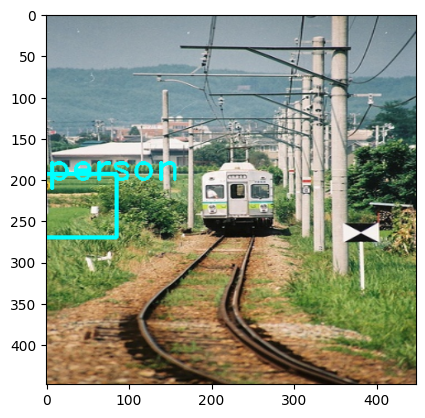

In [ ]:
np_img = cv2.imread('./datasets/VOCdevkit_test/VOC2007/JPEGImages/000002.jpg')
resized_img = cv2.resize(np_img, (IMAGE_SIZE, IMAGE_SIZE))
np_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
resized_img = np_img
np_img = np_img.astype(np.float32)
np_img = np_img / 255.0 * 2 - 1
np_img = np.reshape(np_img, (1, IMAGE_SIZE, IMAGE_SIZE, 3))

y_pred = YOLO(np_img, training=False)
xmin, ymin, xmax, ymax, class_num, conf = process_outputs(y_pred)
class_name = classes_name[class_num]
cv2.rectangle(resized_img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 255), 3)
cv2.putText(resized_img, class_name, (0, 200), 2, 1.5, (0, 255, 255), 2)

plt.imshow(resized_img)
plt.show()

As you can see, the result of current model needs some improvements. After training, your model shall have at least the capability to output prediction like this:

![](https://nthu-datalab.github.io/ml/competitions/Comp_02_Object-Detection/img_src/demo_train.png)

## Other Models

### [Fast-RCNN](https://www.cv-foundation.org/openaccess/content_iccv_2015/papers/Girshick_Fast_R-CNN_ICCV_2015_paper.pdf)

#### Roi pooling ([api source](https://github.com/deepsense-ai/roi-pooling))

Region of interest pooling (RoI pooling) is an operation widely used in object detecion tasks using convolutional neural networks. It was proposed by Ross Girshick ([paper](https://arxiv.org/pdf/1504.08083.pdf)) and it achieves a significant speedup of both training and testing. It also maintains a high detection accuracy. The layer takes two inputs:

1. A fixed-size feature map obtained from a deep convolutional network with many convolutions and max pooling layers.
2. An N-by-5 matrix of representing a list of regions, where N is a number of RoIs. The first columns represents the image index and the remaining four are the coordinates of the top left and bottom right corners of the region.

![](https://nthu-datalab.github.io/ml/competitions/Comp_02_Object-Detection/img_src/ROI-pooling.png)

What does the RoI pooling actually do? For every region of interest from the input list, it takes a section of the input feature map that corresponds to it and scales it to some pre-defined size (e.g., 7×7). The scaling is done by:

1. Dividing the region proposal into equal-sized sections (the number of which is the same as the dimension of the output)
2. Finding the largest value in each section
3. Copying these max values to the output buffer

The result is that from a list of rectangles with different sizes we can quickly get a list of corresponding feature maps with a fixed size.

![](https://nthu-datalab.github.io/ml/competitions/Comp_02_Object-Detection/img_src/roi_pooling.gif)

#### Faster-RCNN

The main idea is use the last conv layers to infer region proposals. Faster-RCNN consists of two modules.

1. Region Proposal Network (RPN): Gives a set of rectangles based on deep convolution layer.
2. Fast-RCNN RoI Pooling layer: Classify each proposal, and refining proposal location.

![](https://nthu-datalab.github.io/ml/competitions/Comp_02_Object-Detection/img_src/Faster_Rcnn.png)


#### [SSD](https://arxiv.org/pdf/1512.02325.pdf)

Single-Shot Multi Box Detector is a model based on YOLO, but it has better ability to detect diverse scale objects.

- [reference](https://arxiv.org/abs/1512.02325)



## Precautions

### Scoring and Report

Your score will be part of the final private result on Kaggle and part of your report.

- Your report(`.ipynb` file) should have:
        
    1. Your code
    2. What kind of models you have tried and how did they work.
    3. Anything you've done and want to tell us.
    4. What problems occured and how did you solve them.

- Also, please upload the `.py` file exported from your `.ipynb` file.

### What you can do

- Implement other models **by yourself**.
- Load pretrained models trained on ImageNet. e.g. vgg19, resnet, etc. (ex. tf.keras.application)
- Data augmentation.

### What you should NOT do

- Load pretrained object detection model weights directly from other sources.
- Clone other's project from github or other sites. (You should implement by yourself).
- Plagiarize codes from other teams.
- Pretrain your network on other dataset (you can only use the pascal data we provided on Kaggle).
- Use the groundtruth to generate output.

### Competition timeline

- 2023/11/09 (Thu) competition announced
- 2023/11/23 (Thu) 23:59 competition deadline
- 2023/11/26 (Sun) 23:59 report deadline
- 2023/11/30 (Thu) top 3 team sharing

